Before attempting to load data, make sure to standardize your excel sheet to make your life easier.
The excel sheet should have:
-Consistent category/column labels across subjects
-First row is category/column labels
-Keep extra information elsewhere
-Be 'snug' left and top (we want it to be a simple table starting with corner cell)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
import seaborn as sns
from scipy.signal import butter, hilbert, filtfilt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime
import os

In [12]:
def get_mood_data(file_name):
    """
    Evaluates an excel spreadsheet for IMS metrics and timestamps. Returns
    a list of the depression and anxiety scores and a list of times.

    Inputs:
    file_name - a standardized excel sheet with category labels in the first row.
    """
    df = pd.read_excel(file_name)
    df = df[['time', 'depression score', 'anxiety score']].dropna()
    dep_score = [int(i) for i in df['depression score']]
    anx_score = [int(i) for i in df['anxiety score']]
    return list(dep_score), list(anx_score), list(df['time'])

def get_neural(neural_data):
    """
    Loads in the neural dataset and returns an array of the samples, an array of time,
    and sampling frequency.

    Inputs:
    neural_data: h5 file containing neural data
    """
    # Load neural data
    fin = h5py.File(neural_data, 'r')

    # Express channels
    chan_label = fin.get('chanLabels')[()]

    if isinstance(chan_label, bytes):
        chan_clean = chan_label.decode('utf-8').replace("'",'').replace(',','').replace('[','').replace(']','')
        chan_label = chan_clean.split()

    # Evaluate time
    t_start = fin.get('start_timestamp')[()]
    t_start_utc = datetime.datetime.utcfromtimestamp(int(t_start))

    # Extract neural data
    data_ecog = fin.get('dataset')
    fs = int(fin.get('f_sample')[()])
    t = np.linspace(0, len(data_ecog[0]) / fs, len(data_ecog[0]))
    total_time = len(data_ecog[0]) / fs
    t_end_utc = t_start_utc + datetime.timedelta(seconds = total_time)
    return data_ecog, chan_label, t, t_start_utc, t_end_utc, fs


def get_windows(neural_data, ims_file_name, window_length):
    """
    Splices an h5 dataset into windows of neural activity corresponding to
    VAS measures. Returns None if no IMS records within neural recording.

    Inputs:
    neural_data - h5 file containing neural data and labels
    ims_file_name - standardized excel sheet containing ims information
    window_length - length of extraction windows in minutes
    """
    # Load vas data
    dep_score, anx_score, ims_timestamps = get_mood_data(ims_file_name)

    # Load neural data
    data_mood, chs, t, t_start, t_end, fs = get_neural(neural_data)

    # Establish time buffers for adequate samples
    t_end_buffer = t_end - datetime.timedelta(seconds=60*window_length/2) # ensure enough samples
    t_start_buffer = t_start + datetime.timedelta(seconds=60*window_length/2)

    # Calculate timestamps and target sample
    ims_times = [x.to_pydatetime().timestamp() - t_start.timestamp() for x in ims_timestamps if t_start_buffer < x < t_end_buffer]
    if len(ims_times) == 0:
        return None, None, None, None, None, None
    dep_score_tracker = [dep_score[i] for i in range(len(dep_score)) if t_start_buffer < ims_timestamps[i] < t_end_buffer]
    anx_score_tracker = [anx_score[i] for i in range(len(anx_score)) if t_start_buffer < ims_timestamps[i] < t_end_buffer]
    target_sample = [int(i) * fs for i in ims_times]
    # Create windows
    window_length_s = window_length*60*fs
    start_frame = [int(i - window_length_s/2) for i in target_sample]
    stop_frame = [int(i + window_length_s/2) for i in target_sample]

    # Extract windows
    neural_windows = np.zeros((len(target_sample), len(chs), stop_frame[0] - start_frame[0]))
    file_tracker = []

    for i in range(len(target_sample)):
        neural_windows[i, :, :] = data_mood[:, start_frame[i]:stop_frame[i]]
        file_tracker.append(neural_data)
    
    return neural_windows, dep_score_tracker, anx_score_tracker, fs, chs, file_tracker, target_sample


def extract_windows(directory, ims_file_name, window_length, output_name):
    """
    Joins multiple windows of neural data together, maintaining
    associated labels.
    
    Inputs:
    directory - a path to the directory containing eeg data
    ims_file_name - an excel spreadsheet of IMS records
    window_length - length of extraction windows in minutes
    output_name - resultant h5 file
    """

    # Initialize combined arrays / list
    combined_windows = None
    combined_target_sample = None
    combined_dep_score = None
    combined_anx_score = None
    combined_file_tracker = []

    # Sort neural data chronologically
    sorted_dir = sorted(os.listdir(directory))
    if '.DS_Store' in sorted_dir:
        sorted_dir.remove('.DS_Store')
    
    for file in sorted_dir:
        neural_windows, dep_score_tracker, anx_score_tracker, fs, chs, file_tracker, target_sample = get_windows(directory + file, 
                                                                               ims_file_name,
                                                                               window_length)
        # Skip over files without IMS records
        if dep_score_tracker is None:
            continue

        # Evaluate, starting with first dataset containing VAS records
        print('Extracting ' + str(len(dep_score_tracker)) + ' IMS from ' + file)
        if len(combined_file_tracker) == 0:
            combined_windows = neural_windows
            combined_target_sample = target_sample
            combined_dep_score = dep_score_tracker
            combined_anx_score = anx_score_tracker
            combined_file_tracker = file_tracker
            fsample = fs
            channels = chs
        else:
            combined_windows = np.concatenate([combined_windows, neural_windows])
            combined_file_tracker = combined_file_tracker + file_tracker
            combined_target_sample = np.concatenate([combined_target_sample, target_sample])
            combined_dep_score = np.concatenate([combined_dep_score, dep_score_tracker])
            combined_anx_score = np.concatenate([combined_anx_score, anx_score_tracker])

    # Create h5 file
    ims_out = h5py.File(output_name, "w")
    ims_out.create_dataset("neural_windows", data=combined_windows, chunks=True)
    ims_out.create_dataset("depression score", data=combined_dep_score)
    ims_out.create_dataset("anxiety score", data=combined_anx_score)
    ims_out.create_dataset("fs", data=fsample, dtype='i8')
    ims_out.create_dataset("file", data=combined_file_tracker)
    dt = h5py.special_dtype(vlen=str)
    ims_out.create_dataset("channels", data=channels, dtype=dt)
    ims_out.create_dataset("target_sample", data=combined_target_sample, dtype = 'i')
    print('Extraction Complete')
    return


In [14]:
#Main

directory = '/Users/haleh/Documents/School/UW/Research/Jeffery Herron/Mood Variation Decoding/Neural Data/eb06df40 Neural/' #specific subject and day name
output = 'IMS_eb06df40_6_20min.h5'

extract_windows(directory=directory, ims_file_name='survey responses_ims.xlsx', window_length=20, output_name=output)

ValueError: could not broadcast input array from shape (129,600000) into shape (1268,600000)

In [ ]:
# Plotting original ieeg with selected extractions of data to verify
import h5py
neural_data = "/Users/haleh/Documents/School/UW/Research/Jeffery Herron/Mood Variation Decoding/Coding and Analysis/processed_eb06df40_6.h5" #specific subject and day name

output = 'IMS_eb06df40_6_15min.h5'

# Import h5 Files
extraction = h5py.File(output, 'r')
original= h5py.File(neural_data, 'r')
file_track = extraction.get('file')[()]

# Extract necessary datasets
paindata = extraction.get('neural_windows')
target_sample = extraction.get('target_sample')[()]
intensity = extraction.get('intensities')[()]
fs = extraction.get('fs')[()]
data_ecog = original.get('dataset')

# plotting confirmation: adjust the arange for the given file based on intensity index in file
for i in np.arange(15, 25):
    plt.subplots(1)
    plt.plot(data_ecog[30, target_sample[i] - int(7.5*60*fs):(target_sample[i] + int(7.5*60*fs))], label = "Original")
    plt.plot(paindata[i,30,:], label = "Extracted", alpha=0.5)
    plt.xlabel('Samples', fontsize = 16)
    plt.ylabel('Voltage (uV)', fontsize = 16)
    plt.legend()
    plt.title('VAS validation, pain intensity: ' + str(intensity[i]), fontsize = 16)
    plt.tight_layout()

In [46]:
# Gather input for neural data
## Import local data
neural_data = "processed_eb06df40_6.h5" #specific subject and day name, in .h5 format
fin = h5py.File(neural_data,'r')

# channel labels - stored as a byte array, convert to np
chan_label = fin.get('chanLabels')[()]
chan_label = np.matrix(chan_label).A[0]

# Extract the starting time in utc
timestamp = fin.get('start_timestamp')[()]
start_timestamp = datetime.datetime.fromtimestamp(int(timestamp))
start_utc = datetime.datetime.utcfromtimestamp(int(timestamp))

# Import dataset and dataset components
data_ecog = fin.get('dataset')
fs = int(fin.get('f_sample')[()])

# Establish time array in seconds
t = np.linspace(0,len(data_ecog[0])/fs,len(data_ecog[0]))

# Calculate stop time in utc
total_time = len(data_ecog[0])/fs
end_utc = start_utc + datetime.timedelta(seconds = total_time)
print('New dataset starting at ' + str(start_utc) + ' and stopping at ' + str(end_utc))
print(chan_label)



New dataset starting at 2019-09-21 08:01:25 and stopping at 2019-09-22 08:32:06.118000
['Event' 'LPI1' 'LPI3' 'LPI5' 'LPI7' 'LPI9' 'LPI15' 'LAMFG1' 'LAMFG2'
 'LAMFG3' 'LAMFG4' 'LAMFG5' 'LAMFG6' 'LAMFG7' 'LAMFG8' 'LAMFG9' 'LAMFG10'
 'LAMFG11' 'LAMFG12' 'LMMFG1' 'LMMFG2' 'LMMFG3' 'LMMFG4' 'LMMFG5' 'LMMFG6'
 'LMMFG7' 'LMMFG8' 'LMMFG9' 'LMMFG10' 'LPMFG1' 'LPMFG2' 'LPMFG3' 'LPMFG4'
 'LPMFG5' 'LPMFG6' 'LPMFG7' 'LPMFG8' 'LPMFG9' 'LPMFG10' 'LPMFG11'
 'LPMFG12' 'LAACC1' 'LAACC2' 'LAACC3' 'LAACC4' 'LAACC5' 'LAACC6' 'LAACC7'
 'LAACC8' 'LAACC9' 'LAACC10' 'LAACC11' 'LAACC12' 'LDACC1' 'LDACC2'
 'LDACC3' 'LDACC4' 'LDACC5' 'LDACC6' 'LDACC7' 'LDACC8' 'LDACC9' 'LDACC10'
 'LDACC11' 'LDACC12' 'LOPER1' 'LOPER3' 'LOPER5' 'LOPER7' 'LOPER9' 'LPCC1'
 'LPCC3' 'LPCC5' 'LPCC7' 'LPCC9' 'LPCC11' 'LPCC13' 'LPCC15' 'RAI1' 'RAI3'
 'RAI5' 'RAI7' 'RPI1' 'RPI3' 'RPI5' 'RPI7' 'RPI9' 'RPI11' 'RPI13' 'RPI15'
 'RAMFG1' 'RAMFG2' 'RAMFG3' 'RAMFG4' 'RAMFG5' 'RAMFG6' 'RAMFG7' 'RAMFG8'
 'RAMFG9' 'RAMFG10' 'RMMFG1' 'RMMFG2' 'RMMFG

In [48]:
## MOOD
# Calculate the time (target sample) of ims relative to start

# here we want to remove any empty rows (there's probably an easier way)
ims_times = [ims_time[idxs[i-1]] for i in np.arange(len(depression_score))]
print(ims_times)
#ims_times = ims_time
# convert to useable timestamps within neural window
ims_mood_time = [ims_times[i].to_pydatetime().timestamp() for i in np.arange(len(ims_times)) if start_utc <= ims_times[i] <= end_utc]

# collect the corresponding mood values
ims_mood_sum = [total_score[i] for i in np.arange(len(ims_times)) if start_utc<= ims_times[i] <= end_utc]
ims_mood_dep = [depression_score[i] for i in np.arange(len(ims_times)) if start_utc<= ims_times[i] <= end_utc]
ims_mood_anx = [anxiety_score[i] for i in np.arange(len(ims_times)) if start_utc<= ims_times[i] <= end_utc]
print("anxiety scores are: ", ims_mood_anx)

# now align it to the start of the neural data
ims_mood_relative = [ims_mood_time[i] - start_utc.timestamp() for i in np.arange(len(ims_mood_time))]

## Create target sample when mood is collected
target_sample = [int(ims_mood_relative[i]*fs) for i in np.arange(len(ims_mood_relative))]
print(target_sample)

[Timestamp('2019-09-21 19:08:00'), Timestamp('2019-09-21 12:15:00'), Timestamp('2019-09-21 16:35:00')]
anxiety scores are:  [12, 11, 15]
[19997500, 7607500, 15407500]


In [49]:
##establish a window of samples to keep the neural data for using window_lenght 

# Print total time of datasset
print("Elapsed time for this data is " + str(end_utc - start_utc))

## Create testing frame
if len(target_sample) == 0:
    print("No applicable vas from this day")
    exit()

# Establish focus windows and drug-effects window
window_length = 10 #in seconds
test_window = fs*window_length*60 # 60 minutes*60 seconds*fs = test window samples
#ims_window = fs*window_length*60 # 60 minutes*60 seconds*fs = drug window samples

# Create start and stop points for the target samples
start_frame = [int(target_sample[i] - test_window) for i in np.arange(len(target_sample))]
stop_frame = [int(target_sample[i] + test_window) for i in np.arange(len(target_sample))]

# Establish window length
window_sample_length = int(stop_frame[0]-start_frame[0]) #0 is the first IMS length, same for all
print(window_sample_length)
# Establish zero array for mood data output
imsdata = np.zeros((len(target_sample),len(chan_label), window_sample_length))

data_day = []
# Extract mood data for each IMS collection
for i in range(len(target_sample)):
    imsdata[i,:,:] = data_ecog[:,start_frame[i]:stop_frame[i]] 
    data_day.append(int(neural_data[-4])) #takes the day value from original dataset

data_day = np.array(data_day)
print("There are " + str(len(imsdata)) + " IMS scores in this data")

output = 'testims_' + neural_data[10:20] + 'NEW2' + '.h5'



Elapsed time for this data is 1 day, 0:30:41.118000
600000
There are 3 IMS scores in this data


In [44]:
# Establish h5 file
imsout = h5py.File(output, "w")
print(str(output) + " is being created")

# Establish datasets with desired labels such as channel labels, total score amd ims data
imsout.create_dataset("ims data", data = imsdata, chunks=True, maxshape=(len(target_sample), len(chan_label), window_sample_length))
imsout.create_dataset("fs", data = fs)
dt = h5py.special_dtype(vlen=str)
chan_label = np.array(chan_label, dtype=dt) 
imsout.create_dataset("chan_label", data = chan_label)
imsout.create_dataset("total score", data = ims_mood_sum)
imsout.create_dataset("depression score", data = ims_mood_dep)
imsout.create_dataset("anxiety score", data = ims_mood_anx)
imsout.create_dataset("dataset_day", data = data_day, chunks = True, maxshape = (10,))
imsout.create_dataset("target_sample", data = target_sample, dtype = 'i', chunks=True, maxshape=(len(ims_times),))
imsout.create_dataset("start_sample", data=start_frame, dtype = 'i', chunks=True, maxshape=(len(ims_times),))
imsout.create_dataset("stop_sample", data = stop_frame, dtype = 'i', chunks=True, maxshape=(len(ims_times),))

imsout.close()

testims_eb06df40_6NEW2.h5 is being created


In [46]:
print(chan_label)

<Closed HDF5 dataset>


<ipython-input-58-21980a735aae>:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  original= h5py.File(neural_data)


['anxiety score', 'chan_label', 'dataset_day', 'depression score', 'fs', 'ims data', 'start_sample', 'stop_sample', 'target_sample', 'total score']
(3, 129, 600000)


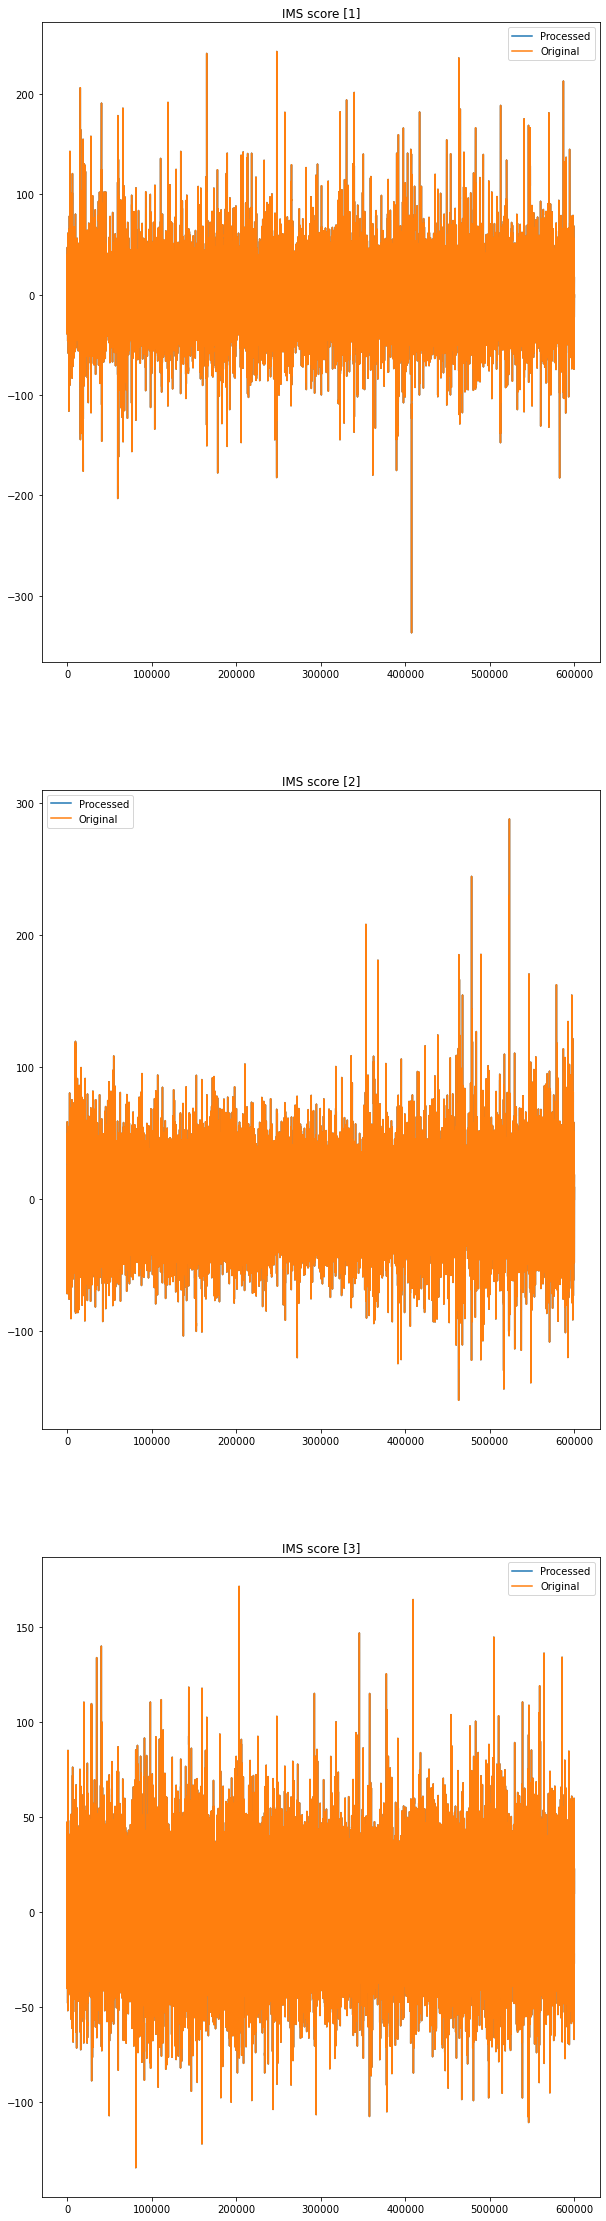

In [58]:
# Plotting original ecog with selected extractions of data to verify
import h5py

# Import h5 Files
extraction = h5py.File(output, 'r')
original= h5py.File(neural_data)
print(list(extraction.keys()))

# Extract necessary datasets
chan_label = extraction.get('chan_label')
imsdata = extraction.get('ims data')
start_sample = extraction.get('start_sample')
stop_sample = extraction.get('stop_sample')
total_score = extraction.get('total score')
depression_score = extraction.get('depression score')
anxiety_score = extraction.get('anxiety score')
fs = extraction.get('fs')
data_ecog = original.get('dataset')

print(imsdata.shape)

# Plotting first instance
plt.figure(figsize = [10,40])
channel = 10
for i in np.arange(len(start_sample)):
    plt.subplot(len(target_sample),1,i+1)
    plt.plot(imsdata[i,channel,:], label = "Processed")
    plt.plot(data_ecog[channel,start_sample[i]:stop_sample[i]], label = "Original")
    plt.legend()
    plt.title('IMS score ' + str([i+1]))

extraction.close()
original.close()